## Customer-Segmentation-Small-Project

In [ ]:
# pip install pandas numpy matplotlib seaborn nltk sklearn wordcloud plotly

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
import nltk
import warnings
import itertools
import datetime
from pathlib import Path
from sklearn import preprocessing, cluster, model_selection, metrics, svm, ensemble, decomposition, linear_model, tree
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display, HTML
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot

In [3]:
py.init_notebook_mode(connected=True) #specific to Plotly. configures Plotly to work in the Jupyter notebook environment.
warnings.filterwarnings("ignore") #sets up a filter to suppress certain types of warnings in the notebook.
plt.rcParams["patch.force_edgecolor"] = True #configuration for Matplotlib. It sets the edge color for patches (e.g., bars in a bar chart) to be more visible.
plt.style.use('fivethirtyeight') #sets the style for Matplotlib plots. In this case, it's using the 'fivethirtyeight' style, which emulates the style of graphics used by the website FiveThirtyEight
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1) #configuration for Matplotlib, appearance of elements like bars in a plot

### 1. Data preparation

The encoding="ISO-8859-1" argument specifies the character encoding used in the file. ISO-8859-1 (also known as Latin-1) is a commonly used encoding for files that contain characters from Western European languages.  
This dataframe contains 8 variables that correspond to:  
**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

In [4]:
# read the datafile
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 8)


#### Step-1

In [5]:
# show first 10 lines and data frame info
display(df_initial.head(10))
display(df_initial.info())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


None

#### Step-2

In [6]:
# Drop null values
df_dropna = df_initial.dropna()
# Show no.of rows before and after the action.
print(f'Number of rows before dropping null values: {df_initial.shape[0]}')
print(f'Number of rows after dropping null values: {df_dropna.shape[0]}')

Number of rows before dropping null values: 541909
Number of rows after dropping null values: 406829


#### Step-3

In [7]:
# Drop Duplicate Rows.
df_drop_duplicates = df_dropna.drop_duplicates()
# Show no.of rows before and after the action.
print(f'Number of rows before dropping duplicate rows: {df_dropna.shape[0]}')
print(f'Number of rows after dropping duplicate rows: {df_drop_duplicates.shape[0]}')
df_cleaned = df_drop_duplicates

Number of rows before dropping duplicate rows: 406829
Number of rows after dropping duplicate rows: 401604


#### Step-4

In [8]:
# Countries where orders are made 
# df_cleaned[['CustomerID', 'InvoiceNo', 'Country']] is a new DataFrame with only three columns
# The following line counts the number of rows with unique combinations of CustomerID, InvoiceNo, and Country and the result is stored in a new DataFrame called temp.
temp = df_cleaned[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts() #The result is a Series where the index represents unique countries and the values represent the count of orders made from each country.
#print(countries)

In [9]:
# Plot Choropleth World Map displaying the number of orders per country. 
# It specifies the data, layout, and color scale for the map using Plotly's API. 
# Finally, it uses the Plotly offline module to display the map.

# defining a dictionary called data which contains various parameters needed to create the choropleth map.
data = dict(
            type='choropleth', #specifies that we're creating a choropleth map.
            locations = countries.index, # .index is used to access the index labels of countries Series, i.e. the country names
            locationmode = 'country names', # tells Plotly to interpret the values in locations as country names
            z = countries, #sets the values associated with each country, which will determine the color on the map. In this case, it's the number of orders.
            text = countries.index, #provides the text that will be displayed when one hovers over each country.
            colorbar = {'title':'No. of Orders placed'}, #sets the title for the colorbar.
            colorscale=[
                        [0, 'rgb(224,255,255)'],
                        [0.01, 'rgb(166,206,227)'], 
                        [0.02, 'rgb(31,120,180)'],
                        [0.03, 'rgb(178,223,138)'], 
                        [0.05, 'rgb(51,160,44)'],
                        [0.10, 'rgb(251,154,153)'], 
                        [0.20, 'rgb(255,255,0)'],
                        [1, 'rgb(227,26,28)']
                       ],
            reversescale = False #specifies that the colors should not be reversed.
        )

# defining a dictionary called layout which contains parameters related to the layout and appearance of the map.
layout = dict(
                title='Number of orders per country',
                geo = dict(showframe = True, projection={'type':'mercator'})
            )

# creating a Figure object using the provided data and layout. 
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap)

#### Step-5

In [10]:
# Exploring the Cancelled Orders

df_cancelled_orders = df_cleaned[
                            df_cleaned['InvoiceNo'].str.startswith('C')
                        ]

temp = df_cancelled_orders[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(
            type='choropleth', 
            locations = countries.index, 
            locationmode = 'country names', 
            z = countries, 
            text = countries.index, 
            colorbar = {'title':'No. of Cancelled Orders'}, 
            colorscale=[
                        [0, 'rgb(224,255,255)'],
                        [0.01, 'rgb(166,206,227)'], 
                        [0.02, 'rgb(31,120,180)'],
                        [0.03, 'rgb(178,223,138)'], 
                        [0.05, 'rgb(51,160,44)'],
                        [0.10, 'rgb(251,154,153)'], 
                        [0.20, 'rgb(255,255,0)'],
                        [1, 'rgb(227,26,28)']
                       ],
            reversescale = False 
        )

layout = dict(
                title='Number of cancelled orders per country',
                geo = dict(showframe = True, projection={'type':'mercator'})
            )

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap)

In [11]:
#Exploring how many unique stock numbers are there 
unique_stock_numbers = df_cleaned['StockCode'].nunique()
print(f'Number of unique stock numbers: {unique_stock_numbers}')

#Exploring the number of unique products sold by exploring number of unique Stock Codes
# Filter out cancelled orders
valid_orders = df_cleaned[~df_cleaned['InvoiceNo'].str.startswith('C')]
# Finding unique stock numbers in valid orders
unique_stock_numbers = valid_orders['StockCode'].nunique()
print(f'Number of unique stock numbers (excluding cancelled orders): {unique_stock_numbers}')

Number of unique stock numbers: 3684
Number of unique stock numbers (excluding cancelled orders): 3665


In [12]:
# Exploring prices
# Summary Statistics
price_summary = valid_orders['UnitPrice'].describe()
print("Price Summary Statistics:")
print(price_summary)

Price Summary Statistics:
count    392732.000000
mean          3.125596
std          22.240725
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64


### 2. Categorize the products using nltk, data encoding and clustering

Code for keyword extraction below:

The function takes as input the dataframe and analyzes the content of the Description column of the dataframe by performing the following operations:
- Extract the names (proper, common) appearing in the products description.
- For each name, extract the root of the word and aggregate the set of names associated with this particular root, and count the number of times each root appears in the dataframe.
- When several words are listed for the same root, consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants).

In [13]:
# my_string = "Hi I am Megha!"
# my_string[:2]

In [14]:
# pos[:2] == 'NN' checks if the first two characters extracted from the input are equal to 'NN'.
# acts as a filter condition to identify all kinds of nouns.
is_noun = lambda string: string[:2] == 'NN'
stemmer = nltk.stem.SnowballStemmer("english") #creating an instance of the Snowball stemmer specifically configured for the English language, will be used to find the root form of words.

def keywords_inventory(dataframe, column='Description'):
    
    keywords_roots = dict()  # store the root forms of words along with their associated words.
    keywords_select = dict()  # establish association: root <-> selected keyword
    category_keys = [] # list used to store selected keywords.
    count_keywords = {keyword: 0 for keyword in category_keys} # dictionary used to keep track of the count of each keyword. It will store the number of times each root form appears in the data.Initialising the count as 0 for each keyword
    
    for s in dataframe[column]: #for each element in the column of the dataframe
        if pd.isnull(s): continue
        lines = s.lower() 
        tokenized = nltk.word_tokenize(lines) # This line tokenizes (splits) the text in lines into individual words, creating a list of tokens. This step is essential for further processing.
        # This following line uses nltk.pos_tag() to tag each token with its associated part of speech. It then filters the tokens to include only those identified as nouns by the is_noun function.
        nouns = [word for (word, tag) in nltk.pos_tag(tokenized) if is_noun(tag)]
# This following code is building a dictionary (keywords_roots) where each key is a stemmed root form of a word, and the value associated with each key is a set of words that share that same root. 
# Additionally, count_keywords keeps track of how many times each root form appears in the data.
        for t in nouns:
            t = t.lower(); #ensuring consistency in word comparisons, as Python is case-sensitive.
            root = stemmer.stem(t) #stems t using the Snowball stemmer initialized earlier. The stemmed form is assigned to root.
# If root is already in keywords_roots, it means that this root has been encountered before. In that case:
# keywords_roots[root].add(t): The original word t is added to the set of words associated with this root.
# count_keywords[root] += 1: The count of this root is incremented to keep track of how many times it appears.
            if root in keywords_roots:
                keywords_roots[root].add(t)
                count_keywords[root] += 1
# If root is not in keywords_roots, it means this is the first time this root is encountered. In that case:
# keywords_roots[root] = {t}: A new set containing only t is created and associated with this root.
# count_keywords[root] = 1: The count of this root is initialized to 1.
            else:
                keywords_roots[root] = {t}
                count_keywords[root] = 1

# This following code is selecting the "representative" word for each root form, favoring the shortest word when there are multiple options. 
# The selected words are stored in category_keys, and the association between roots and selected words is stored in keywords_select
    for root in keywords_roots.keys():
# if there is more than one associated word for the current root form (s)
        if len(keywords_roots[root]) > 1:
            min_length = 1000 # used to keep track of the shortest word associated with the root.
            for word in keywords_roots[root]: # iterates over all the associated words for the current root.
                if len(word) < min_length:
                    shortest_word = word;
                    min_length = len(word)
            category_keys.append(shortest_word) #at the end of iteration, the shortest word is added to the category_keys list
            keywords_select[root] = shortest_word
        else:
            category_keys.append(list(keywords_roots[root])[0]) # The first (and only) word associated with this root is added to the category_keys list.
            keywords_select[root] = list(keywords_roots[root])[0]

    print("Number of keywords in variable '{}': {}".format(column, len(category_keys))) #len(category_keys) gives the total number of keywords found in that column.
    return category_keys, keywords_roots, keywords_select, count_keywords

#### Step-1 <br>
Plot the keywords vs number of occurences

In [15]:
# # Testing on the first 10 rows (a subset of df_cleaned)
# df_subset = df_cleaned.head(10)
# category_keys, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_subset)
# # Extracting keywords and occurrences
# keywords = list(count_keywords.keys())
# occurrences = list(count_keywords.values())
# # Plotting the keywords vs. occurrences
# plt.figure(figsize=(12, 6))
# sns.barplot(x=keywords, y=occurrences, palette='viridis')
# # Adding labels and title
# plt.title('Keywords vs. Number of Occurrences')
# plt.xlabel('Keywords')
# plt.ylabel('Number of Occurrences')
# # Rotating x-axis labels for better visibility (optional)
# plt.xticks(rotation=90)
# # Display the plot
# plt.show()

In [16]:
category_keys, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_cleaned)

Number of keywords in variable 'Description': 1483


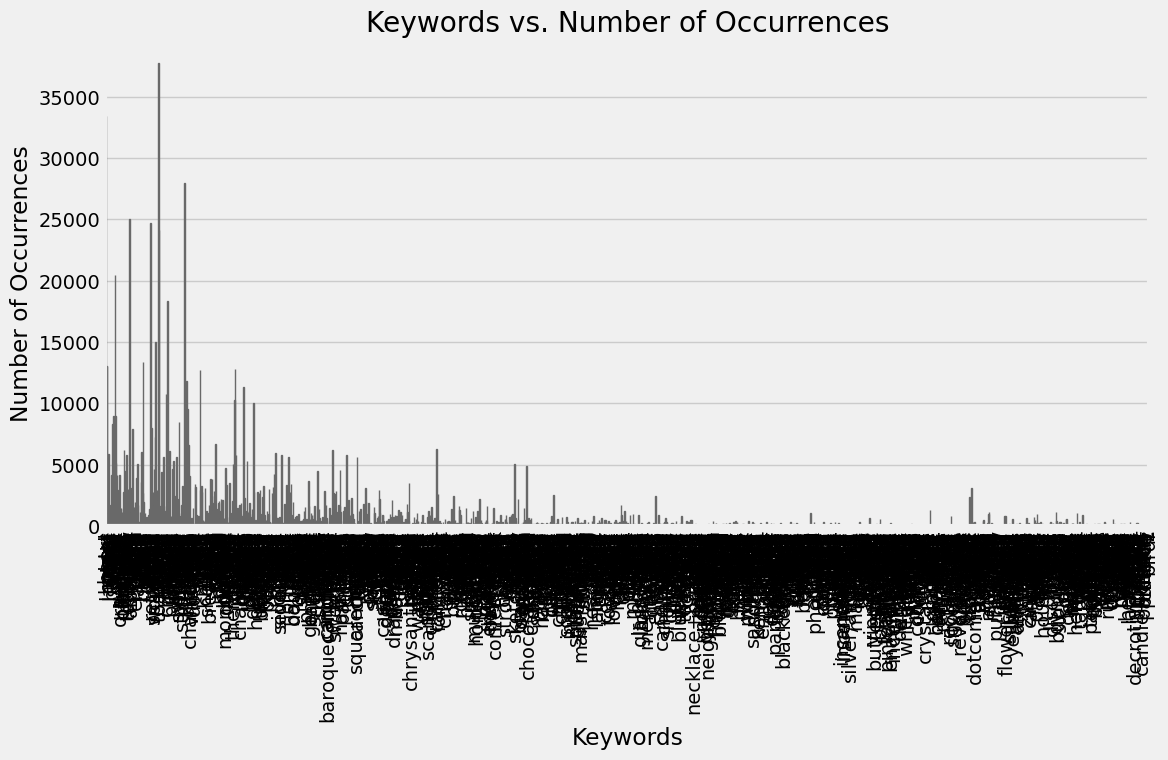

In [17]:
# Extracting keywords and occurrences
keywords = list(count_keywords.keys())
occurrences = list(count_keywords.values())
# Plotting the keywords vs. occurrences
plt.figure(figsize=(12, 6))
sns.barplot(x=keywords, y=occurrences, palette='viridis')
# Adding labels and title
plt.title('Keywords vs. Number of Occurrences')
plt.xlabel('Keywords')
plt.ylabel('Number of Occurrences')
# Rotating x-axis labels for better visibility (optional)
plt.xticks(rotation=90)
# Display the plot
plt.show()

#### STEP 2
Eliminate occurances below a certain threshold
Encode product description with keywords and other relevant info, if any, in a matrix

In [24]:
# Performing one-hot encoding, 
# One-hot encoding should not be used if variables take more than 15 different values, here the variable keyword takes 1483 values 
# Hence eliminating some of the keywords below a certain threshold, i.e. ones with 10,000 occurences

threshold = 12500
filtered_keywords = {k: v for k, v in count_keywords.items() if v >= threshold}
print(f'Number of items in the filtered_keywords dictionary: {len(filtered_keywords)}')

{'heart': 33402, 'holder': 13014, 'metal': 13040, 'box': 20477, 'vintag': 25035, 'pink': 13358, 'retrospot': 24694, 'lunch': 14980, 'bag': 37737, 'design': 24110, 'christma': 18308, 'set': 27929, 'sign': 12689, 'tin': 12757}
Number of items in the filtered_keywords dictionary: 14


In [19]:
# 'encoded_df' will contain the original dataframe with one-hot encoded keywords
encoded_df = df_cleaned.copy()
for keyword in filtered_keywords.keys():
    encoded_df[keyword] = encoded_df['Description'].str.lower().str.contains(keyword).astype(int)
# encoded_df.head(10)

In [20]:
# # Encode product description with keywords and other relevant info, if any, in a matrix

# # Creating a DataFrame with binary values for keywords
# # index=df_cleaned.index to ensure no problems during concatenation later 
# keywords_df = pd.DataFrame(0, columns=filtered_keywords.keys(), index=df_cleaned.index)
# # Iterate through each row in the dataframe
# # df_cleaned.iterrows() is a method provided by pandas DataFrame, which yields index and row data for each row in the DataFrame.
# # this loop processes each row's description, tokenizes it, identifies nouns, and extracts their root forms. It then checks if these roots are among the filtered keywords. If so, it updates the keywords_df DataFrame to indicate the presence of these keywords for that particular product.
# for idx, row in df_cleaned.iterrows():
#     descr = row['Description']
#     if pd.notnull(descr):
#         descr = descr.lower()
#         tokens = nltk.word_tokenize(descr)
#         nouns = [word for (word, tag) in nltk.pos_tag(tokens) if is_noun(tag)]
#         for t in nouns:
#             t = t.lower()
#             root = stemmer.stem(t)
#             if root in filtered_keywords:
#                 keywords_df.at[idx, root] = 1

# # Concatenating the original dataframe with the keywords DataFrame
# encoded_df = pd.concat([df_cleaned, keywords_df], axis=1) #axis parameter specifies that the concatenation should be done along the columns (i.e., side by side).
# # Dropping the 'Description' column as it's no longer needed
# encoded_df.drop('Description', axis=1, inplace=True)
# # Now 'encoded_df' contains the original dataframe with one-hot encoded keywords
# encoded_df.head(10)

#### STEP 3
Use kmeans to cluster products

In [21]:
# Normalize Price
# StandardScaler is a preprocessing step that scales the data so that it has a mean of 0 and a standard deviation of 1. This is important because it can make some algorithms (like K-means) work more effectively.
scaler = StandardScaler()
encoded_df['NormalizedPrice'] = scaler.fit_transform(encoded_df[['UnitPrice']]) #applies the scaling to the 'UnitPrice' column in encoded_df, and the scaled values are stored in a new column called 'NormalizedPrice' in encoded_df.
# Now 'encoded_df' contains the original data with normalized price
# encoded_df.head(10)
for column_name, data_type in encoded_df.dtypes.items():
    print(f"Column '{column_name}' has data type: {data_type}")

Column 'InvoiceNo' has data type: object
Column 'StockCode' has data type: object
Column 'Description' has data type: object
Column 'Quantity' has data type: int64
Column 'InvoiceDate' has data type: object
Column 'UnitPrice' has data type: float64
Column 'CustomerID' has data type: object
Column 'Country' has data type: object
Column 'heart' has data type: int32
Column 'holder' has data type: int32
Column 'metal' has data type: int32
Column 'box' has data type: int32
Column 'vintag' has data type: int32
Column 'pink' has data type: int32
Column 'retrospot' has data type: int32
Column 'lunch' has data type: int32
Column 'bag' has data type: int32
Column 'design' has data type: int32
Column 'christma' has data type: int32
Column 'set' has data type: int32
Column 'sign' has data type: int32
Column 'tin' has data type: int32
Column 'NormalizedPrice' has data type: float64


In [22]:
to_cluster_df = encoded_df.loc[:, 'heart':'NormalizedPrice']

# Deciding the best number of clusters using silhouette score as a criterion
# Defining a range of cluster numbers to test
cluster_range = range(2, 4)  
best_silhouette_score = -1
best_num_clusters = 1
for num_clusters in cluster_range:
    # Applying K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(to_cluster_df)
    # Calculate silhouette score
    silhouette_avg = silhouette_score(to_cluster_df, clusters)
    # Update best silhouette score and number of clusters 
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = num_clusters

print(f"The best number of clusters is: {best_num_clusters} with a silhouette score of {best_silhouette_score}")

KeyboardInterrupt: 

In [ ]:
# Applying K-means Clustering
kmeans = KMeans(n_clusters=best_num_clusters, random_state=0) #random_state=0 ensures that the results are reproducible.  
clusters = kmeans.fit_predict(to_cluster_df) #fits the K-means model to the data and assigns each data point to a cluster. The resulting cluster labels are stored in the clusters variable.
to_cluster_df['ClusterLabel'] = clusters #cluster labels are added as a new column 'ClusterLabel' to the encoded_df DataFrame.

#### STEP 4
Plot results in a Word Cloud

In [25]:
# Converting dictionary to list of tuples
list_products = list(filtered_keywords.items())
print(list_products)

[('heart', 33402), ('holder', 13014), ('metal', 13040), ('box', 20477), ('vintag', 25035), ('pink', 13358), ('retrospot', 24694), ('lunch', 14980), ('bag', 37737), ('design', 24110), ('christma', 18308), ('set', 27929), ('sign', 12689), ('tin', 12757)]
